# 데이콘 데이터 설명
링크: https://dacon.io/competitions/official/235949/overview/description

데이터: https://drive.google.com/file/d/1qA5_vLnNAxzJuiOKQkgL8CAIAESaxCi9/view

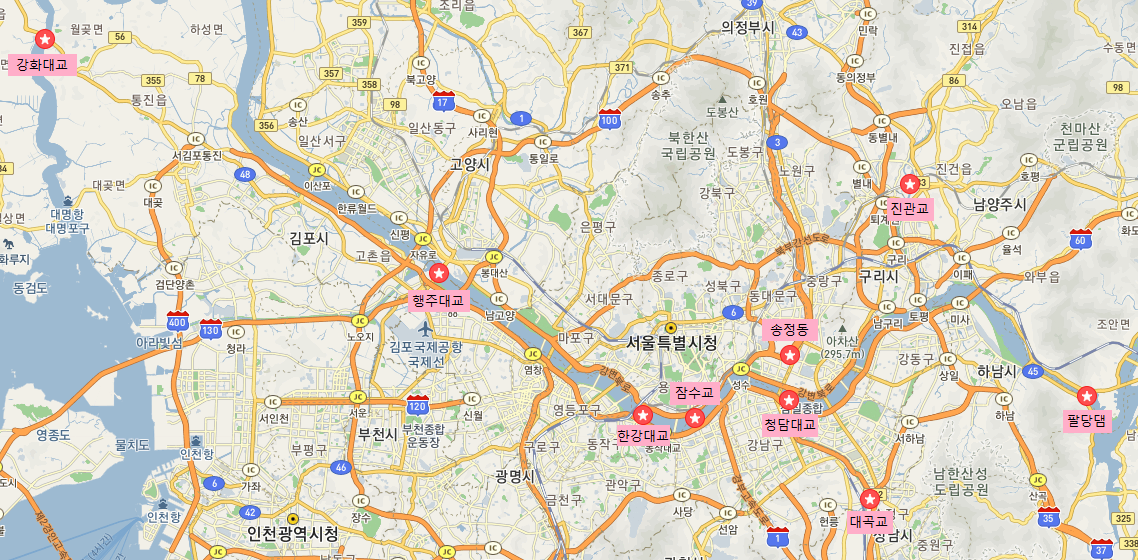

좌측부터

강화대교(조위), 행주대교(수위,유량), 한강대교(수위,유량), 잠수교(수위,유량),

청담대교(수위,유량), 송정동(강수량), 대곡교(강수량), 진관교(강수량), 팔당댐(..)


https://dacon.io/competitions/official/235949/talkboard/406535?page=1&dtype=recent
```
Data
├ Water Data
│ ├ data_2012.csv
│   ├ ymdhm : 년월일시분
│   ├ swl : 팔당댐 현재수위 (단위: El.m)
│   ├ inf : 팔당댐 유입량 (단위: m^3/s)
│   ├ sfw : 팔당댐 저수량 (단위: 만m^3)
│   ├ ecpc : 팔당댐 공용량 (단위: 백만m^3)
│   ├ tototf : 팔당댐 총 방류량 (단위: m^3/s)
│   ├ tide_level : 강화대교 조위 (단위: cm)
│   ├ wl_1018662 : 청담대교 수위 (단위: cm)
│   ├ fw_1018662 : 청담대교 유량 (단위: m^3/s)
│   ├ wl_1018680 : 잠수교 수위 (단위: cm)
│   ├ fw_1018680 : 잠수교 유량 (단위: m^3/s)
│   ├ wl_1018683 : 한강대교 수위 (단위: cm)
│   ├ fw_1018683 : 한강대교 유량 (단위: m^3/s)
│   ├ wl_1019630 : 행주대교 수위 (단위: cm)
│   └ fw_1019630 : 행주대교 유량 (단위: m^3/s)
│ ├ data_2013.csv
…
└ └ data_2022.csv
└ RainFall Data
│ ├ rf_2012.csv
│   ├ YMDHM : 년월일시분
│   ├ rf_10184100 : 대곡교 강수량
│   ├ rf_10184110 : 진관교 강수량
│   └ rf_10184140 : 송정동 강수량
│ ├ rf_2013.csv
…
└ └ rf_2022.csv
```

# 제출 데이터 형식(청담대교, 잠수교, 한강대교, 행주대교)
```
ymdhm	wl_1018662	wl_1018680	wl_1018683	wl_1019630
2022-06-01 00:00	0	0	0	0
2022-06-01 00:10	0	0	0	0
2022-06-01 00:20	0	0	0	0
...
2022-07-18 23:30	0	0	0	0
2022-07-18 23:40	0	0	0	0
2022-07-18 23:50	0	0	0	0
```



# 평가 규칙
* 평가 산식: RMSE / R_Squared_Score
* R_Squared_Score <= 0인 경우 999출력
* 각 다리의 예측된 수위에 대한 점수를 평균하여 리더보드에 표시

# 외부 데이터 및 사전 학습 모델
* 경진대회를 위해 적법하게 활용 가능한 외부 데이터 활용 가능. 
* 사전 학습 모델(pre-trained Model) 사용 가능.

In [26]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# %는 magic commands, !는 bash command.
# cd와 같은 경우는 임시 서브셸에서 실행되기 때문에 디렉토리가 영구적으로 변경되지 않는다.
# 매직 명령어를 실행해야 영구적으로 변경된다.
%cd '/content/drive/MyDrive/Colab Notebooks/08.09 중간 프로젝트/'
path = '/content/drive/MyDrive/Colab Notebooks/08.09 중간 프로젝트/'

/content/drive/MyDrive/Colab Notebooks/08.09 중간 프로젝트


In [28]:
!unzip -o -qq competition_data.zip -d competition_data

In [29]:
import pandas as pd
import numpy as np
import os

## 1. 데이터 불러오기

In [30]:
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path,files]),
                            index_col=index_col)
        df_raw = pd.concat((df_raw,df),axis=0)
    return df_raw

In [31]:
_df_rf_raw = read_csv_by_dir('/'.join([path,'competition_data/rf_data']), index_col=0)
_df_water_raw = read_csv_by_dir('/'.join([path,'competition_data/water_data']), index_col=0)
_submission_raw = pd.read_csv('/'.join([path,'competition_data/sample_submission.csv']), index_col=0)

In [32]:
# raw_data 보존하기
df_rf=_df_rf_raw.copy()
df_rf.name = "rain_data"
df_water=_df_water_raw.copy()
df_water.name = "water_data"
submission=_submission_raw.copy()
submission.name = "submission"

## 2. 데이터 전처리

In [34]:
def index_to_datetime(df,format):
    df.index = pd.to_datetime(df.index, format=format)
    return df

In [35]:
df_rf=index_to_datetime(df=df_rf,format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water,format='%Y-%m-%d %H:%M')
submission=index_to_datetime(df=submission,format='%Y-%m-%d %H:%M')

In [36]:
df_rf.sort_index(inplace=True)
df_water.sort_index(inplace=True)
submission.sort_index(inplace=True)

In [37]:
# 데이터 시간대 확인하기
def check_datetime(df):
    print(df.name)
    print(df.select_dtypes('datetime64[ns]').head(1).index[0])
    print(df.select_dtypes('datetime64[ns]').tail(1).index[0])
    return None

check_datetime(df_rf)
check_datetime(df_water)
check_datetime(submission)

rain_data
2012-05-01 00:00:00
2022-07-18 23:50:00
water_data
2012-05-01 00:00:00
2022-07-18 23:50:00
submission
2022-06-01 00:00:00
2022-07-18 23:50:00


In [38]:
# data target 분리하기
target = df_water.loc[:,submission.columns]
data = pd.concat((df_rf,df_water.drop(submission.columns,axis=1)),axis=1)

In [40]:
total=pd.concat((data,target),axis=1)
total=total.sort_index()
total.head(1)

,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,,,,,,,,,,,,,,
2012-05-01,0.0,0.0,0.0,24.8,555.0,219.07,24.93,555.0,445.0,469.05,0.0,729.8,540.18,310.7,300.2,290.0,275.3


In [41]:
train_data=total.loc[:"2022-05-31",:"fw_1019630"].reset_index(drop=True)
train_target=total.loc[:"2022-05-31","wl_1018662":].reset_index(drop=True)
test_data=total.loc["2022-06-01":,:"fw_1019630"].reset_index(drop=True)
test_target=total.loc["2022-06-01":,"wl_1018662":].reset_index(drop=True)

In [42]:
train_data.fillna(train_data.mean(), inplace=True)
train_target.fillna(train_target.mean(), inplace=True)
test_data.fillna(train_data.mean(), inplace=True)
test_target.fillna(train_target.mean(), inplace=True)

In [43]:
print(f'train data shape {train_data.shape}')
print(f'train target shape {train_target.shape}')
print(f'test data shape {test_data.shape}')
print(f'test target shape {test_target.shape}')

train data shape (269424, 13)
train target shape (269424, 4)
test data shape (6912, 13)
test target shape (6912, 4)


## 3-1. modeling & predicting(ML)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=2, shuffle=True)
rf = RandomForestRegressor(n_jobs=-1)
params = { "n_estimators" : (100, 150, 200) } #  (100, 150, 200) # 1 step 당 10분
grid_cv = GridSearchCV(rf, param_grid=params, cv = kfold, n_jobs=-1)

In [ ]:
grid_cv.fit(train_data,train_target) 

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_estimators': [200]})

In [ ]:
print(grid_cv.best_estimator_)
print(grid_cv)

RandomForestRegressor(n_estimators=200, n_jobs=-1)


In [ ]:
pred=grid_cv.predict(test_data)
pred  # 점수: 3.3379

array([[278.51 , 272.97 , 273.605, 269.07 ],
       [280.765, 268.625, 271.075, 267.5  ],
       [283.435, 271.73 , 271.48 , 263.79 ],
       ...,
       [296.155, 305.93 , 307.765, 311.615],
       [309.83 , 309.01 , 311.17 , 312.23 ],
       [324.885, 315.9  , 317.29 , 312.405]])

## 3-2. modeling & predicting(DL)

In [44]:
!nvidia-smi

Thu Aug 11 00:52:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    30W /  70W |    418MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D, Dropout

In [169]:
from keras import backend
def rmse_ev(y_true, y_pred):
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred), axis=-1)**0.5 # backend.mean
def mse_ev(y_true, y_pred):
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred), axis=-1)
def r2_score_ev(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    R_squared = tf.subtract(1.0, tf.math.divide(residual, total_error))
    return R_squared

In [170]:
# loss function 정의
# from sklearn.metrics import mean_squared_error, r2_score
def div_rmse_r2score(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    y_pred = tf.convert_to_tensor(y_pred)
    sum = 0
    for i in range(len(tf.transpose(y_pred))):
        rmse = rmse_ev(tf.transpose(y_true)[i], tf.transpose(y_pred)[i])
        r2score = r2_score_ev(tf.transpose(y_true)[i], tf.transpose(y_pred)[i])
        sum += rmse/r2score
    return sum/4

In [200]:
model = Sequential()
model.add(LSTM(256, input_shape=(13,1), return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences = False))
model.add(Dense(4, activation = 'relu'))

optimizer = tf.optimizers.RMSprop(0.001)

model.compile(optimizer=optimizer,loss=div_rmse_r2score)
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 13, 256)           264192    
                                                                 
 dropout_3 (Dropout)         (None, 13, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_35 (Dense)            (None, 4)                 516       
                                                                 
Total params: 461,828
Trainable params: 461,828
Non-trainable params: 0
_________________________________________________________________


In [217]:
real = pd.read_csv(path+"평가지표/평가지표데이터.csv")
real.reset_index()
real.drop('ymdhm', axis=1, inplace=True)
real.head(1)

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,278.7,275.7,273.7,268.7


In [ ]:
## 적합한 스텝을 찾기 위한 반복문 early stopping 사용 x
output=[]
for epoch in range(20, 50, 5):
    model = Sequential()
    model.add(LSTM(256, input_shape=(13,1), return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences = False))
    model.add(Dense(4, activation = 'relu'))
    optimizer = tf.optimizers.RMSprop(0.001)
    model.compile(optimizer=optimizer,loss=div_rmse_r2score)
    # print(model.summary())

    history = model.fit(train_data, train_target, epochs=epoch, batch_size=128, validation_data=(test_data, real))
    pred = model.predict(test_data)
    pred_df=pd.DataFrame(pred)
    pred_df['blank'] = ""
    pred_df = pred_df[['blank',0,1,2,3]]
    pred_df.rename(columns={'blank':'ymdhm',0:"wl_1018662",1:"wl_1018680",2:"wl_1018683",3:"wl_1019630"},inplace=True)
    print(f"epoch: {epoch} // {calc.score(pred_df)}") # 점수: 3.3379
    output.append(f"epoch: {epoch} // {calc.score(pred_df)}")

print("="*80)
for i in output:
    print(i)

Epoch 1/20
2105/2105 [==============================] - 24s 10ms/step - loss: -32.5705 - val_loss: -70.0601
Epoch 2/20
2105/2105 [==============================] - 20s 9ms/step - loss: -30813.2324 - val_loss: 18.8767
Epoch 3/20
2105/2105 [==============================] - 21s 10ms/step - loss: 41.7172 - val_loss: 12.2355
Epoch 4/20
2105/2105 [==============================] - 19s 9ms/step - loss: 19.3439 - val_loss: 4.6393
Epoch 5/20
2105/2105 [==============================] - 20s 10ms/step - loss: 13.7568 - val_loss: 4.3882
Epoch 6/20
2105/2105 [==============================] - 20s 9ms/step - loss: 11.3095 - val_loss: 8.2693
Epoch 7/20
2105/2105 [==============================] - 20s 10ms/step - loss: 10.0719 - val_loss: 7.0575
Epoch 8/20
2105/2105 [==============================] - 21s 10ms/step - loss: 9.3670 - val_loss: 8.1784
Epoch 9/20
2105/2105 [==============================] - 19s 9ms/step - loss: 8.8432 - val_loss: 8.6654
Epoch 10/20
2105/2105 [=============================

## 4. evaluating

In [145]:
# 평가 산식: RMSE/R_Squared_Score, 각 다리의 점수를 구한 뒤 평균
import warnings; warnings.filterwarnings('ignore')
from google import colab
colab.drive.mount("/content/drive")
%cd '/content/drive/MyDrive/Colab Notebooks/08.09 중간 프로젝트/평가지표/'
try:
    import import_ipynb
except:
    !pip -q install import_ipynb
    import import_ipynb

from evaluate import calc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/08.09 중간 프로젝트/평가지표
importing Jupyter notebook from evaluate.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
pred_df=pd.DataFrame(pred)
pred_df['blank'] = ""
pred_df = pred_df[['blank',0,1,2,3]]
pred_df.rename(columns={'blank':'ymdhm',0:"wl_1018662",1:"wl_1018680",2:"wl_1018683",3:"wl_1019630"},inplace=True)
calc.score(pred_df) # 점수: 3.3379

점수: 1.2155

1.215537252030258
